# TP 2-3 : Branch-and-bound applied to a knapsack problem

## Questions préliminaires

    1. Quelle est la règle de séparation ? 

La règle de séparation se situe dans la fonction « SeparerNoeud_lexicographic_depthfirst! ». On va choisir la 1ère variable fractionnaire xk dans l’ordre croissant de ratio. On crée un nœud sur le premier nœud rencontré, non fixé. Et après séparation, on se retrouve avec 2 nouvelles branches xk = 0 & xk = 1.

    2. Quelle est la méthode de calcul de borne supérieure ? 

La méthode de calcul de la borne supérieur réside dans les fonctions set_lower_bound & set_upper_bound. Le but du TP est d’ailleurs de modifier ces fonctions pour ajouter de nouveaux calculs de la borne supérieure. En effet, on ne sait pas précisément comment ces fonctions calculs la borne supérieure.

Pour calculer l'upperbound, le programme somme les objets déjà dans le sac même s’ils ne sont pas entièrement mis dans le sac (ratio d'objets possible).
   
    3. Quels sont les tests de sondabilité TA, TO, TR ? 

Les tests de sondabilité sont dans la fonction « TestsSondabilite_LP ». 
-	Le test d’admissibilité (TA) qui vérifie que la capacité restante est bien positive avec la fonction « termination_status ».
-	Le test d’admissibilité (TO) qui vérifie que la borne supérieure est mieux que la meilleure solution connue du problème d’optimisation avec la fonction « objective value » .
-	Le test de résolution (TR) qui vérifie que la solution optimale n’est pas entière avec la fonction. 

    4. Quelle est la stratégie d’exploration ? 

On priorise l’exploration de l’enfant gauche, puis, on revient sur le père et sur l’enfant droit. C’est ce que l’on appelle une stratégie PSES qui a pour avantage d’utiliser moins d’espace mémoire et de trouver plus vite la solution réalisable.

## Analyse du code

    1. Donner les points clés de votre implémentation.

La règle de séparation est la même qu'avant, on va choisir la 1ère variable fractionnaire xk dans l’ordre croissant de ratio. On crée un nœud sur le premier nœud rencontré, non fixé. Et après séparation, on se retrouve avec 2 nouvelles branches xk = 1 & xk = 0.

Le calcul de la borne supérieure est lui bien différent. Il existe 2 méthodes différentes de calcul.

- La borne 1 ("simple"), la lowerbound est le profit du sous-problème. Pour calculer la upper bound, on ajoute à la lowerbound à la capacité courrante multipliée par le ratio de la variable courante.
- La borne 2 ("methode2"), la upperbound est l'évaluation de la fonction objectif du sous problème.

Les tests de sondabilité sont dans la fonction TestSondabilite. TA réussi si la capacité restante est négative, TR réussi si la solution optimale est entière pour la méthode avec la borne 1, et TO réussi si la borne supérieure est pire que la meilleure solution connue.

La règle d'exploration est la même qu'avant. On priorise l’exploration du fils gauche, puis, on retourne à la racine et on explore le fils droit. C’est ce que l’on appelle une stratégie PSES qui a pour avantage d’utiliser moins d’espace mémoire et de trouver plus vite la solution réalisable.

    2. Expliquer votre choix de structure de données.

Pour le modèle on a créé un constructeur "model", on a instancié plusieurs attributs à model dont x qui est défini par le constructeur "variable". L'utilisation de cette structure de données nous permet d'accéder et de modifier facilement les différentes variables du problème.

    3. Comparer les performances du Branch-and-Bound en utilisant la borne 1 ou la borne 2.

La méthode 2 semble plus performante que la methode simple car il y a moins de noeuds. 

Pour la solution finale il faut prendre en compte qu'elle est donnée en ayant classé les variables par ordre décroissant de ratio, ainsi pour l'exemple test on obtient $BestProfit = 65$ et $x=[0,1,0,1]$.

### Initialisation (à faire une seule fois)

In [1]:
import Pkg; 
Pkg.add("GraphRecipes"); Pkg.add("Plots"); 
using GraphRecipes, Plots #only used to visualize the search tree at the end of the branch-and-bound

    Updating registry at `~/.julia/registries/General.toml`
   Resolving package versions...
  No Changes to `~/.julia/environments/v1.8/Project.toml`
  No Changes to `~/.julia/environments/v1.8/Manifest.toml`
   Resolving package versions...
  No Changes to `~/.julia/environments/v1.8/Project.toml`
  No Changes to `~/.julia/environments/v1.8/Manifest.toml`


### Récupération des données

In [2]:
function readKnaptxtInstance(filename)
    price=[]
    weight=[]
    KnapCap=[]
    open(filename) do f
        for i in 1:3
            tok = split(readline(f))
            if(tok[1] == "ListPrices=")
                for i in 2:(length(tok)-1)
                    push!(price,parse(Int64, tok[i]))
                end
            elseif(tok[1] == "ListWeights=")
                for i in 2:(length(tok)-1)
                    push!(weight,parse(Int64, tok[i]))
                end
            elseif(tok[1] == "Capacity=")
                push!(KnapCap, parse(Int64, tok[2]))
            else
                println("Unknown read :", tok)
            end 
        end
    end
    capacity=KnapCap[1]
    return price, weight, capacity
end

readKnaptxtInstance (generic function with 1 method)

### Tests de sondabilités TA, TO et TR basés sur le modèle linéaire

In [3]:
function TestsSondabilite(model, BestProfit, Bestsol)
    TA, TO, TR = false, false, false
    
    #Test de faisabilite
    if(!model.feasable) # réussi si la capacité restante est négative
        TA=true
        println("TA")
        
    #Test d'optimalite
    elseif(model.UpBound <= BestProfit) # réussi si la borne supérieure est pire que la meilleure solution connue
        TO=true
        println("TO")
        
    #Test de resolution
    elseif(Resolution(model)) # réussi si la solution optimale est entière
        TR=true
        println("TR")
        if (objective(model) >= BestProfit)
            Bestsol = [var.value for var in model.x]
            BestProfit = objective(model)
            println("\nNew Solution memorized ", Bestsol, " with bestprofit ", BestProfit, "\n")
        end
    else
        println("Noeud non sondable")
    end
    TA, TO, TR, Bestsol, BestProfit
end

TestsSondabilite (generic function with 1 method)

In [4]:
function Resolution(model)
    resolution = false
    current_capacity = model.capacity
    
    if model.method == "simple"
        for (index, var) in enumerate(model.x)
            if var.free
                current_capacity = model.capacity - sum(var.value * model.weight[var.index] for var in model.x)
                weight = model.weight[var.index]
                var.value = weight <=  current_capacity  ? 1.0 : 0.0
                if (var.value == 0.0) # valeur binaire et non fractionnaire
                    resolution = true
                else
                    resolution = false
                end
                break
            end
        end
        
    elseif model.method == "methode2"
        resolution = prod(abs.([round.(var.value, digits=0) for var in model.x]-[var.value for var in model.x]) .<= fill(10^-5, size(model.x))) 

    end
        
    return resolution
end

Resolution (generic function with 1 method)

## Procédure de séparation (branching) et stratégie d'exploration permettant de se placer au prochain noeud à traiter

In [5]:
function SeparerNoeud(model, listx, listvals)
    # ce noeud n'est pas sondable. Appliquer le critère de séparation pour le séparer en deux sous-nœuds
    # et choisir le noeud-fils de gauche  

    new_x = Array{variable, 1} # la variable du futur noeud-fils de gauche
    
    if model.method == "simple"
        for (i, var) in enumerate(model.x)
            if var.free # si la variable var est libre (disponible dans le sac)
                # set var
                var = model.x[i]
                var.free = false # cette var n'est plus disponible dans la suite
                var.value = 1.0

                new_x = var
                break
            end
        end
        
    elseif model.method == "methode2"
        for (i, var) in enumerate(model.x)
            if var.free && (abs(round(var.value, digits=0) - var.value ) >= 10^-5)
                # set var
                var = model.x[i]
                var.free = false # cette var n'est plus disponible dans la suite
                var.value = 1.0
            
                new_x = var
            break
        end
    end

        
    end
    
    #println("\nbranch on variable ", new_x, "\n")

    # depthfirst exploration strategy: the node selected will be the most left of the child-nodes just created
    push!(listx,new_x) #save the identity of the object selected for branching
    push!(listvals,1.0) #save the node selected, identified by the value assigned to the variable/object chosen
    return listx, listvals
end


function ExplorerAutreNoeud(model, listx, listvals, listnodes)
    #ce noeud est sondable, retourner au noeud parent puis au fils droit si possible.
    
    stop=false
    #check if we are not at the root node
    if (length(listx)>= 1)
        #go back to parent node
        var=pop!(listx)
        theval=pop!(listvals)
        tmp=pop!(listnodes)
            
        # Le noeud parent est à nouveau sondable
        var.free = true
        
        #go to right child if possible, otherwise go back to parent
        while( (theval==0.0) && (length(listx)>= 1))
            var=pop!(listx)
            theval=pop!(listvals)
            tmp=pop!(listnodes)
                
            # Le nouveau noeud-fils est sondable
            var.free = true
            var.value = 0.0 # pour le fils droit
                
        end
        if theval==1.0
            
            # Set la var avec la valeur 0.0
            var.free = false
            var.value = 0.0
            
            push!(listx,var)
            push!(listvals,0.0)
        else
            println("\nFINISHED")
            stop=true
        end
    else
        #the root node was sondable
        println("\nFINISHED")
        stop=true
    end
    return listx, listvals, listnodes, stop  
end

ExplorerAutreNoeud (generic function with 1 method)

###  Création de la relaxation linéaire (= modèle associé au noeud 0): <span style="color:red"> SECTION A SUPPRIMER !!!! </span>

<span style="color:red"> Cette section est à commenter/supprimer et remplacer par vos propres calculs de bornes supérieures et autres, par exemple basées sur les bornes 1 et 2 vues en cours, ou d'autres calculs de bornes de votre choix/conception validés au préalable par votre encadrant/e de TP </span>

In [6]:
# Constructeur pour les variables xi, dont l'instance peut être modifiée grâce à mutable
mutable struct variable
    index::Int64
    value::Float64
    free::Bool # pour savoir si c'est une variable décisionnelle qu'on a pas encore explorée
end

# Constructeur du modèle
mutable struct Model
    x::Array{variable, 1}
    price::Array{Int64, 1}
    weight::Array{Int64, 1}
    capacity::Int64
    feasable::Bool # pour le TA
    UpBound::Float64
    LowBound::Float64
    method::String # pour les 2 méthodes
end

function objective(model)
    return sum([var.value * model.price[var.index] for var in model.x])
end


objective (generic function with 1 method)

In [7]:
function CreationModel(price, weight, capacity, method)
    n=length(price)
    
    # Règle de séparation
    # choix de la variable fractionnaire dans l'ordre décroissant du ratio
    ratio = price./weight
    order = sortperm(ratio, rev=true) # renvoie la liste des indices par ordre décroissant de ratio
    
    # Initialisation du modèle
    x = Array{variable, 1}(undef, n)
    for i = 1:n
        x[i] = variable(i ,0.0 ,true) # valeur initialisée à 0
    end
    feasable = true

    UpBound = capacity * ratio[order][1]
    LowBound = 0
    
    model = Model(x, price[order], weight[order], capacity, feasable, UpBound, LowBound, method)
    
    return model
end

CreationModel (generic function with 1 method)

In [8]:
function solve(model)
    
    current_capacity = model.capacity
    current_capacity -= sum(var.value * model.weight[var.index] for var in model.x)
    UpBound = 0
    feasable = current_capacity >= 10^-5 # TA : Q positif   
    
    if feasable
        if model.method == "simple"

            # Calcul de la borne inférieure (profit du (sous-)problème)
            LowBound = sum(var.value * model.price[var.index] for var in model.x) 

            UpBound = LowBound
            for var in model.x
                if var.free
                    # Calcul de la borne supérieure
                    ratio = (model.price[var.index] / model.weight[var.index])
                    UpBound += current_capacity * ratio
                    break
                end
            end

    elseif model.method == "methode2"
            # Parcourir les variables dans l'ordre décroissant du ratio
            for (index, var) in enumerate(model.x) 

                # Si var n'a pas été explorée comme variable de séparation
                if var.free

                    current_capacity -= sum(var.value * model.weight[var.index] for var in model.x)

                    if current_capacity <= 10^-5 # si le sac est plein
                        var.value = 0.0 
                    else  # si on peut encore remplir le sac
                        weight = model.weight[var.index]
                        if weight <= current_capacity # si on peut mettre l'objet en entier
                            var.value = 1.0
                            current_capacity -= weight
                        else  # si on peut mettre une fraction de l'objet
                            var.value = current_capacity / weight
                            current_capacity = 0.0 # on a rempli le sac au maximum
                        end
                    end
                end 
            end
            UpBound = objective(model)

        end
    end
    
    model.feasable = feasable
    #model.LowBound = LowBound
    model.UpBound = UpBound
end

solve (generic function with 1 method)

### Boucle principale : résoudre une relaxation, appliquer les tests de sondabilité, identifier le prochain noeud, répéter.

In [9]:
function SolveKnapInstance(filename)
    
    price, weight, capacity = readKnaptxtInstance(filename)
    model = CreationModel(price, weight, capacity, "methode2")

    #create the structure to memorize the search tree for visualization at the end
    trParentnodes=Int64[] #will store orig node of arc in search tree
    trChildnodes=Int64[] #will store destination node of arc in search tree
    trNamenodes=[] #will store names of nodes in search tree

    #intermediate structure to navigate in the search tree
    listx=[]
    listvals=[]
    listnodes=[]

    BestProfit=-1
    Bestsol=[]

    current_node_number=0
    stop = false
    
    while(!stop)

        println("\nNoeud n°", current_node_number, ": \n---------------\n")

        #Update the graphical tree
        push!(trNamenodes,current_node_number+1) 
        if(length(trNamenodes)>=2)
            push!(trParentnodes,listnodes[end]+1) # +1 because the 1st node is "node 0"
            push!(trChildnodes, current_node_number+1) # +1 because the 1st node is "node 0"
        end
        push!(listnodes, current_node_number)


        print("Solution : ")
        if(!model.feasable)
            println(" NOT AVAILABLE (probably infeasible or ressources limit reached)")
        else
            print(" LB=", objective(model))
            [print("     ", "x", v.index,"=",v.value) for v in model.x] 
        end
        println(" "); 


        #println("\nPrevious Solution memorized ", Bestsol, " with bestprofit ", BestProfit, "\n")
        
        solve(model)
        
        TA, TO, TR, Bestsol, BestProfit = TestsSondabilite(model, BestProfit, Bestsol)

        is_node_sondable = TA || TO || TR


        if(!is_node_sondable)
            #SeparerNoeud_lexicographic_depthfirst!(listobjs, listvals, length(price))
            listx, listvals = SeparerNoeud(model, listx, listvals)

        else
            #stop = ExplorerAutreNoeud_depthfirst!(listobjs, listvals, listnodes)
            listx, listvals, listnodes, stop = ExplorerAutreNoeud(model, listx, listvals, listnodes)
        end
        
        #Reset_allLP!(model2, x)

        current_node_number = current_node_number + 1
    end

    return BestProfit, Bestsol, trParentnodes, trChildnodes, trNamenodes

end


SolveKnapInstance (generic function with 1 method)

### Affichage du résultat final


Noeud n°0: 
---------------

Solution :  LB=0.0     x1=0.0     x2=0.0     x3=0.0     x4=0.0 
Noeud non sondable

Noeud n°1: 
---------------

Solution :  LB=82.0     x1=1.0     x2=1.0     x3=0.0     x4=0.0 
TA

Noeud n°2: 
---------------

Solution :  NOT AVAILABLE (probably infeasible or ressources limit reached)
 
Noeud non sondable

Noeud n°3: 
---------------

Solution :  LB=40.0     x1=1.0     x2=0.0     x3=0.0     x4=0.0 
Noeud non sondable

Noeud n°4: 
---------------

Solution :  LB=65.0     x1=1.0     x2=0.0     x3=1.0     x4=0.0 
TR

New Solution memorized [1.0, 0.0, 1.0, 0.0] with bestprofit 65.0


Noeud n°5: 
---------------

Solution :  LB=40.0     x1=1.0     x2=0.0     x3=0.0     x4=0.0 
TO

Noeud n°6: 
---------------

Solution :  LB=8.0     x1=0.0     x2=0.0     x3=0.0     x4=0.6666666666666666 
TO

FINISHED

******

Optimal value = 65.0

Optimal x=[1.0, 0.0, 1.0, 0.0]


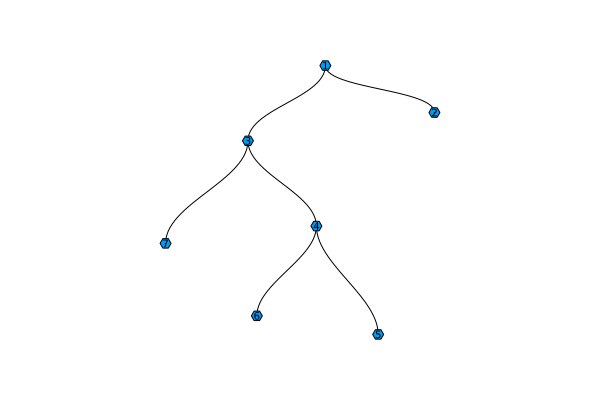

In [10]:
BestProfit, Bestsol, trParentnodes, trChildnodes, trNamenodes = SolveKnapInstance("instancesETU/KNAPnewformat/test.opb.txt")
println("\n******\n\nOptimal value = ", BestProfit, "\n\nOptimal x=", Bestsol)
graphplot(trParentnodes, trChildnodes, names=trNamenodes, method=:tree)